# Process channels 5 to 8
here I will process and save the data fro channels 5 to 8

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from copy import deepcopy#, copy
from shutil import copy2 as copy_file
import math
from sklearn.metrics import r2_score

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly
import plotly.express as px
import kaleido

%load_ext autoreload
%autoreload 2
from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year, import_tlogger
from my_func_mvw.functions import find_nearest_date, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, random_date, carpet_plot_with_gaps,save_values_in_file, statistic_plot, add_nan_val_in_datagaps
from my_func_mvw.additional_corrections import correct_lienar_trend
from my_func_mvw.functions_dts_processing import watertank_shift, cut_dataframe_to_range_tlogger, check_processed_data, calc_mean_for_each_segment, plot_segments_mean_correction, const_shift_data, diff_to_watertank, check_first_last_date

##################### Input ###########################
plot_save=True #True False
masterthesis_save=False # True False
show_large_plot=True #True False
calc_shiftfirst=False #logical wrong way to average the data
data_save=True #True False
do_checks=True #True False
importer="pickle" #pickle; at the moment everything is imported with pickle
########################################################

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

Some Version information of the imported packages
pandas version: 1.3.4
pickle version: 4.0


In [2]:
#Load data
path_DTS_processed = r"..\Alsdorf\Daten\DTS_processed"
# data_2019 = import_my_database_csv(2019, path_to_my_database + r"\csv")
# data_2020 = import_my_database_csv(2020, path_to_my_database + r"\csv")
# data_2021 = import_my_database_csv(2021, path_to_my_database + r"\csv")

# Load pickle Data
data_all = read_pickle(path_DTS_processed + "\import_data_scripts\data_all")

# delete other cable channels
for old_chan in ["1","2","3","4"]:
    del data_all[old_chan]

In [3]:
# Import TLogger
df_Tlogger, df_Tlogger_PT1000 = import_tlogger(path_DTS_processed=path_DTS_processed,importer=importer)
watertank_T_range_min = df_Tlogger.index.min()
watertank_T_range_max = df_Tlogger.index.max()

df_Tlogger

,Channel1-Watertank,Channel2-Air,Channel1_rolling_mean
2021-06-07 12:12:40,23.4,25.8,23.5
2021-06-07 12:13:40,23.5,25.4,23.5
2021-06-07 12:14:40,23.4,25.2,23.5
2021-06-07 12:15:40,23.5,24.9,23.5
2021-06-07 12:16:40,23.5,24.8,23.5
...,...,...,...
2021-10-06 10:49:47,17.7,NaN,17.7
2021-10-06 10:52:47,17.7,NaN,17.7
2021-10-06 10:55:47,17.7,NaN,17.7
2021-10-06 10:58:47,17.7,NaN,17.7


5
330 dates with nan have been added

6
332 dates with nan have been added

7
6 dates with nan have been added

8
7 dates with nan have been added

Number of dates in Channel 5: 1248
Number of dates in Channel 6: 1248
Number of dates in Channel 7: 1248
Number of dates in Channel 8: 1248


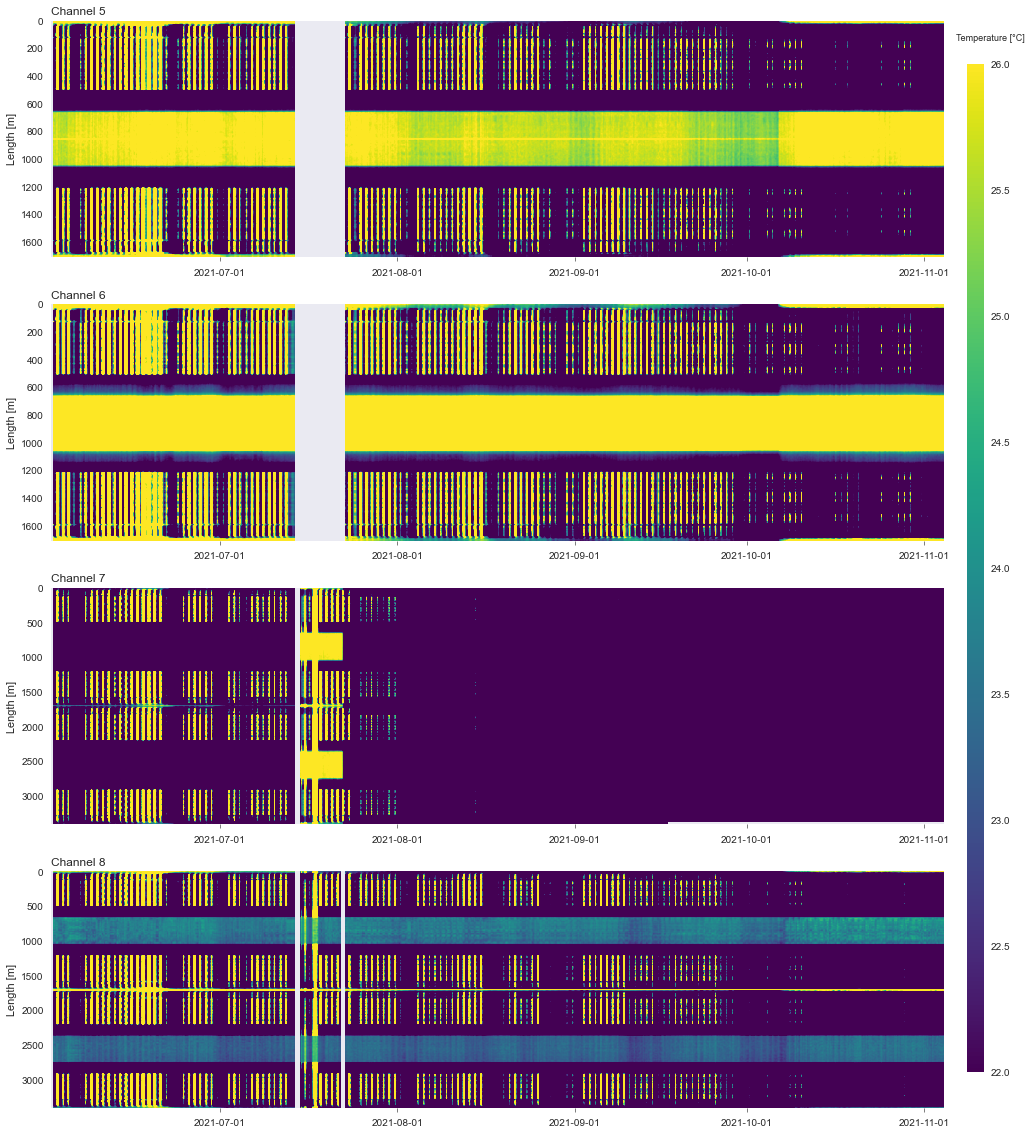

In [4]:
if show_large_plot:     
    carpet_plot_with_gaps(data_all,["5","6","7","8"],title_prefix="",sample_hours=3,vmin=22,vmax=26)
    if plot_save:
        plt.savefig(r"pictures\raw_data_ch58_carpet.png")
        if masterthesis_save:
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix\raw_data_ch58_carpet.pdf", format="pdf",bbox_inches="tight")
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster\raw_data_ch58_carpet.png", format="png",bbox_inches="tight",dpi=300)
    plt.show()

In [5]:
# divide into segments of the same kalibration (QuickStart)
# "22-07-2021 13:30:29" angepasst, sodass es besser zu Daten passt
# "14-07-2021 14:16:59" angepasst, sodass es besser zu Daten passt
# string=["2019-02-15 12:50:44","2019-07-24 12:48:19","2019-12-19 10:10:44","2020-01-29 11:08:25","2020-03-13 17:04:59","2020-03-18 11:49:41",
#     "2020-05-15 10:31:49","2020-12-09 11:02:45", "2021-04-07 12:43:35", "2021-04-26 10:57:11",
#     "2021-04-28 09:41:06", "2021-05-20 16:02:01", "2021-06-01 15:06:12", "14-07-2021 14:16:59", "22-07-2021 13:30:29","2021-10-06 11:01:47"] # from ch 1-4
string=["2021-06-01 15:06:12", "14-07-2021 12:58:00", "22-07-2021 11:50:00", "2021-08-02 11:08:00","2021-10-06 11:01:47"] #adapted for ch 5-8

dates=[pd.to_datetime(s) for s in string] #also used later for plotting
first_date=data_all["5"].index[0]
last_date=data_all["8"].index[-1]

calibration_segments = []
first_segment=[first_date, dates[1]] # first_date entspricht bei diesen channeln ca. erstem QuickStart
last_segment=[dates[-1],last_date]

calibration_segments.append(first_segment)
for i in range(1,len(dates[1:])): #skip first one, because its already first_segment
    segment = [dates[i], dates[i+1]]
    calibration_segments.append(segment)
calibration_segments.append(last_segment)

## Raw data

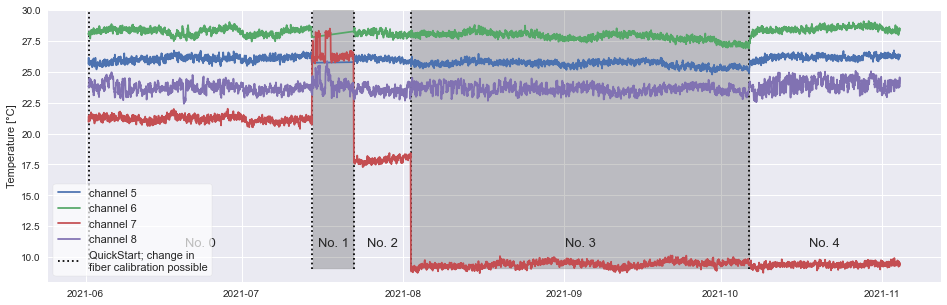

In [6]:
length=800 #change me

# Correction Segments
def color_cable_pos_calb_seg(calibration_segment, alph,axs, ymax=30, ymin=9, col="black", label_name="none", label=False):
    """ creates patches which color the plot
    I slightly adapt this for every notebook
    """
    start_len = datetime.fromtimestamp(calibration_segment[0].timestamp())
    end_len = datetime.fromtimestamp(calibration_segment[1].timestamp())
    width = end_len - start_len
    start_len_num=mdates.date2num(start_len)
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax-ymin,color=col,alpha=alph)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
        date_num=mdates.date2num(start_len+width/2)
        axs.text(date_num,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=13,bbox=bbox_props)

# Plot
fig,axs=plt.subplots(1,1,figsize=(16,5))
axs.vlines(dates,9,30,colors="black",linestyle=":",label="QuickStart; change in\nfiber calibration possible")

for chan in ["5","6","7","8"]:
    axs.plot(data_all[chan][length],label=f"channel {chan}")

# Assecoirs
alph=0.0
counter=0
for segment in calibration_segments:
    color_cable_pos_calb_seg(segment,alph,axs=axs,label_name=f"No. {counter}",label=True)
    if alph == 0.0:
        alph+=0.2
    elif alph == 0.2:
        alph=0.0
    counter+=1

#axs.set_title(f"Uncorrected data, Length: {length}", fontsize=13)
#axs.set_xlabel("Date")
axs.set_ylabel("Temperature [°C]")
axs.set_ylim([8,30]) #8, 30
legend = plt.legend(fontsize=11, title_fontsize=11,frameon=True)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7) #not supported with eps

if masterthesis_save: # Save additional information so I can read them in my tex file
    save_values_in_file(0,"cable_length_plot_raw_data_ch58",length,r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\values_for_read_in_tex.txt")

if plot_save:
    plt.savefig(r"pictures\raw_data_ch58.png")
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\raw_data_ch58.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\raw_data_ch58.png", format="png",bbox_inches="tight",dpi=300)
plt.show()

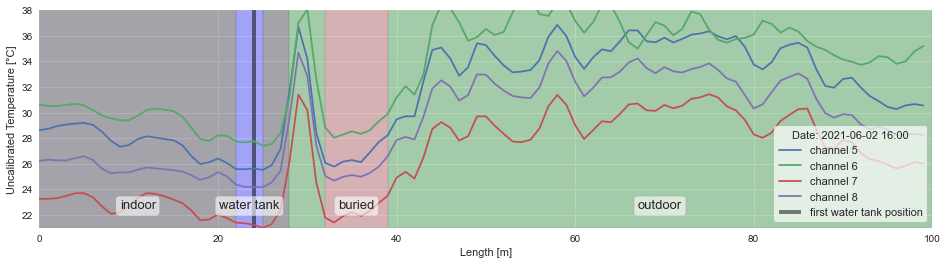

In [7]:
iloc_date_index=50 #change me
ymin=21;ymax=38 #change me

def color_cable_pos(start_len, end_len, alph, axs, ymax=30, ymin=20, col="black", label_name="none", label=False):
    """ creates patches which color the plot
    I slightly adapt this for every notebook
    """
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=ymax-ymin,color=col,alpha=alph)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc="white", ec="0.5", alpha=0.6)
        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.9,label_name,ha="center",va="center",size=13,bbox=bbox_props)

# Plot
fig,axs=plt.subplots(1,1,figsize=(16,4))
for chan in ["5","6","7","8"]:
    data_chan=data_all[chan].iloc[iloc_date_index][:100]
    axs.plot(data_chan,label=f"channel {chan}")

# Assecoirs
date_name=str(data_all["6"].iloc[iloc_date_index].name.round("1h"))[:-3]
axs.set_ylabel("Uncalibrated Temperature [°C]")
axs.set_xlabel("Length [m]")
axs.set_xlim(0,100)
axs.set_ylim(ymin,ymax)
axs.vlines([24],ymin,ymax,label="first water tank position",color="black",linewidth=4,alpha=0.5)

color_cable_pos(0,22,0.3,ymax=ymax,ymin=ymin,axs=axs, label_name="indoor", label=True)
color_cable_pos(22,25,0.3,ymax=ymax,ymin=ymin,axs=axs,col="blue", label_name="water tank", label=True)
color_cable_pos(25,28,0.3,ymax=ymax,ymin=ymin,axs=axs,col="black")
color_cable_pos(28,32,0.3,ymax=ymax,ymin=ymin,axs=axs,col="green", label_name="outdoor", label=False)
color_cable_pos(32,39,0.3,ymax=ymax,ymin=ymin,axs=axs,col="brown", label_name="buried", label=True)
color_cable_pos(39,100,0.3,ymax=ymax,ymin=ymin,axs=axs,col="green", label_name="outdoor", label=True)

legend = axs.legend(fontsize=11, title_fontsize=11,frameon=True,title=f"Date: {date_name}",loc="lower right")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7)

if plot_save:
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix\watertank_loc_raw_ch58.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster\watertank_loc_raw_ch58.png", format="png",bbox_inches="tight",dpi=300)
    plt.savefig("pictures\watertank_loc_raw_ch58.png")
plt.show()

## Alligning

In [8]:
# remove unrealistic values of corrected data - relativ großzügig
data_all_processed=deepcopy(data_all)
a=data_all_processed #for shortening code

for chan in ["5","6"]: # channel 5 and 6: 825 bis 900 a lot of noise in channel 6
    for length in range(850,870,1): # from 850 to 869 m (both inclusive) delete all values
        a[chan][length] = np.nan

for chan in ["7","8"]:
    for length in range(1700,1716,1): # from 1700 to 1715 m (both inclusive) delete all values
        a[chan][length] = np.nan

# drop last value, because chan 5 is "longer" than chan 6; determined by test measurement of DTS device
a["5"] = a["5"].drop(1708,axis=1)

############################################################################################################################
# adapt dataframes so that during avearaging (flipping dataframe columns), the watertank positions are avearaged
# eventually adapt if changing watertank position !!!!!!!!!!!!!!!!
# both dataframes have a length of 1708 now (max value length 1707)
# 1707-25=1682 # 25 position from the back --> 1689 of one channel is not avearaged with 25 of other channel
a["5"] = a["5"].drop([0,1,2,3,4,5,6],axis=1)
a["6"] = a["6"].drop([0,1,2,3,4,5,6],axis=1)

# changed watertank position from 25 to 24
a["5"] = a["5"].drop(a["5"].columns[-1],axis=1)
a["6"] = a["6"].drop(a["6"].columns[-1],axis=1)
# 25 is now index 19 (position 20) and 1689 is index -20; index 0 is avearaged with -1 and so on

a["7"] = a["7"].drop([0,1,2,3,4,5],axis=1)
a["8"] = a["8"].drop([0,1,2,3,4,5],axis=1)
# 25 is now index 19 (position 20) and 3389 is index -20; index 0 is avearaged with -1 and so on
a["7"] = a["7"].drop([1800,1801],axis=1)
a["8"] = a["8"].drop([1800,1801],axis=1)
# 1689 is now index 1683 and 1723 is index -1684

# changed watertank position from 25 to 24
a["7"] = a["7"].drop(a["7"].columns[-1],axis=1)
a["8"] = a["8"].drop(a["8"].columns[-1],axis=1)
a["7"] = a["7"].drop([1660],axis=1)
a["8"] = a["8"].drop([1660],axis=1)


##############################################################################################################################

###################### Correct date missmatch, must be done manually at the moment####################################
a["5"] = a["5"].drop(a["5"].index[1929],axis=0)
a["5"] = a["5"].drop(a["5"].index[4490],axis=0)
a["5"] = a["5"].drop(a["5"].index[5340],axis=0)
a["6"] = a["6"].drop(a["6"].index[5340],axis=0)
a["7"] = a["7"].drop(a["7"].index[5816],axis=0)

# print("--- Before removing date points ---")
# check_first_last_date(a)
# print("--- --- --- --- --- --- --- --- --- ---")

# add new entries here
# dont drop dates at the beginning, some processing uses ilocs, which do not work correct if at the beginning dates are removed

# Check if the changes are as expected
# print("--- After removing some date points ---")
# check_first_last_date(a) # done in next cell anyway
####################################################################################################################

In [9]:
# drop/delete dates which cant be corrected with good results
# drop/delete them also in channel 8 so the data is alligned
ilocs=[2402,2403,2404,2405,2406,2898] 
# 2402: 2021-07-22 10:45:05; 2897: "2021-08-02 11:08:22"
print("variable: data_all_processed")
for chan in ["7","8"]:
    dat=data_all_processed[chan]
    for iloc in ilocs:
        dat.iloc[iloc] = np.nan
        print(f"deleted {dat.iloc[iloc].name} in channel {chan}")

# maybe I should delete at every border some values. Because the device needs some time to warm up. Not needed I think.

variable: data_all_processed
deleted 2021-07-22 10:21:04 in channel 7
deleted 2021-07-22 10:45:05 in channel 7
deleted 2021-07-22 11:09:06 in channel 7
deleted 2021-07-22 11:58:50 in channel 7
deleted 2021-07-22 12:30:52 in channel 7
deleted 2021-08-02 11:06:22 in channel 7
deleted 2021-07-22 10:25:04 in channel 8
deleted 2021-07-22 10:49:05 in channel 8
deleted 2021-07-22 11:13:06 in channel 8
deleted 2021-07-22 12:02:51 in channel 8
deleted 2021-07-22 12:34:52 in channel 8
deleted 2021-08-02 11:10:22 in channel 8


In [10]:
# Create cariable for const shift correction
data_all_processed_withoutTlogger = deepcopy(data_all_processed)

# Check my processed data
my_Warning = check_processed_data(channels=["5","6","7","8"], data_all_processed = data_all_processed_withoutTlogger, gap_end=2404+1, gap_begin=1928+1)
# gap_begin=1928
# gap_end=2404
# # gap_begin=1661
# # gap_end=2137

Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


In [11]:
# Cut dataframes so they only cover the time of the t-Logger
# only cuts start and end does not account for datagaps in tlogger!

# do seperate due to data gaps, therefore iloc of the dates is not corresponding to same date_name in the different channelpairs
data_all_processed_56 = cut_dataframe_to_range_tlogger(channels=["5","6"],data = data_all_processed,do_check=False, 
    watertank_T_range_min = watertank_T_range_min, watertank_T_range_max = watertank_T_range_max)
data_all_processed_78 = cut_dataframe_to_range_tlogger(channels=["7","8"],data = data_all_processed,do_check=False,
    watertank_T_range_min = watertank_T_range_min, watertank_T_range_max = watertank_T_range_max)
data_all_processed["5"] = data_all_processed_56["5"]
data_all_processed["6"] = data_all_processed_56["6"]
data_all_processed["7"] = data_all_processed_78["7"]
data_all_processed["8"] = data_all_processed_78["8"]
del data_all_processed_78; del data_all_processed_56

In [12]:
# Manual correction so indexes of all dataframes fit togehter
a=data_all_processed
a["7"] = a["7"].drop(a["7"].index[0],axis=0)
a["8"] = a["8"].drop(a["8"].index[0],axis=0)
a["7"] = a["7"].drop(a["7"].index[-1],axis=0)
a["8"] = a["8"].drop(a["8"].index[-1],axis=0)

a["5"] = a["5"].drop(a["5"].index[-1],axis=0)
a["6"] = a["6"].drop(a["6"].index[-1],axis=0)

# check_first_last_date(data_all_processed) done in next cell anyway

In [13]:
# Check my processed data
my_Warning = check_processed_data(channels=["5","6","7","8"], data_all_processed = data_all_processed, gap_begin=1661, gap_end=2137)
# gap_begin=1928
# gap_end=2404
# # gap_begin=1661
# # gap_end=2137

# If this fails you most likely need to update the above cell

Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


## Calculate offset and  Shift

In [14]:
#80 s
#24 1689 1723 3389
watertank_len=[24,1689,1723,3389] # position DTS cable, where it is in watertank; before [19,1690,1723,3389] [25,1690,1723,3389]
# keep in mind the dataframe starts not at 0. watertank_len contains the real distances, so dont use .columns[watertank_len[x]]

# Correction for waterteank temp difference
data_all_processed_shifted, watertank_diff_log_data_all = watertank_shift(data_all_processed, df_Tlogger, watertank_len=watertank_len,
                                                    watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

# Calculate mean of channels

In [15]:
def avearge_two_channels(chanx,chany):
    """one channel (chanx) is flipped (length). After that the mean of all values is calculated.
    Only use this for processed data
    """
    # Calculate new index
    # calculate mean of both indexes and check the time difference; checking the time difference is not needed anymore
    # because its already done data processing check. But I think it does not take much computing power, so I keep it here
    time_diff_allowed = 5 # in minutes
    new_index=[]
    for i in range(len(chanx)):
        ts1=chanx.index[i] # ts: timestamp
        ts2=chany.index[i]
        # calculate mean time of both channels, it will be used as index for the result.
        if ts1 > ts2:
            tsmean=ts1-(ts1-ts2)/2
            if ts1-ts2 > timedelta(minutes=time_diff_allowed): 
                print(f"Warning 1: Large time difference between both channels: {ts1-ts2} at index {i}")
        elif ts1 < ts2:
            tsmean=ts2-(ts2-ts1)/2
            if -(ts1-ts2) > timedelta(minutes=time_diff_allowed):
                print(f"Warning 2: Large time difference between both channels: {-(ts1-ts2)} at index {i}")
        else:
            print("Warning 3: Timestamps equal. Not expected")
        new_index.append(tsmean.round(freq="S"))
    new_index=pd.Series(new_index,name="Date") # to series so it can be used in .set_index

    # change index, so they are equal
    chany = chany.set_index(new_index)
    chanx = chanx.set_index(new_index)
    # flip dataframe one channel (channel 5)
    # Two possibilities
    # 1. Flip data of dataframe
    # chanx = chanx[chanx.columns[::-1]] # flip the complete dataframe: columns and data
    # chanx.columns = chanx.columns[::-1] # datframes are added based on column names, so I need to change them in one dataframe
    # 2. flip only columns (rename them), because by adding two dataframes the values with the same column name are added
    chanx_flipped = deepcopy(chanx) # otherwise I will flip the chanx dataframe for the rest of the notebook
    chanx_flipped.columns = chanx_flipped.columns[::-1]
    # calculate mean of Temperature values
    chanxy_mean = (chanx_flipped + chany)/2

    return chanxy_mean # column names original from chany

# Create mean of channels
if calc_shiftfirst:
    chan_mean_shiftfirst={}
    # Caution different than in averagefirst
    chan_mean_shiftfirst["5and6"] = avearge_two_channels(data_all_processed_shifted["5"], data_all_processed_shifted["6"])
    chan_mean_shiftfirst["7and8"] = avearge_two_channels(data_all_processed_shifted["7"], data_all_processed_shifted["8"])
    # columns (length) corresponds to second channel, channel 6 and channel 8

# Avearge first and make the watertank correction after that

In [16]:
#40s
chan_mean_avearagefirst_not_shifted={}
# chan_mean_avearagefirst_not_shifted["5and6"]=avearge_two_channels(data_all_processed["5"], data_all_processed["6"])
# fits better to 7and8 like this
chan_mean_avearagefirst_not_shifted["5and6"]=avearge_two_channels(data_all_processed["6"],data_all_processed["5"])
chan_mean_avearagefirst_not_shifted["7and8"]=avearge_two_channels(data_all_processed["7"], data_all_processed["8"])

chan_mean_avearagefirst={}
# auf Wassertank verschieben bei watertank_len[0] m
chan_mean_avearagefirst, watertank_diff_log_avearagefirst = watertank_shift(chan_mean_avearagefirst_not_shifted, df_Tlogger, channels=["5and6","7and8"], 
                                        watertank_len=watertank_len, watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

# Save processed data

In [17]:
if data_save:
    write_pickle(path_DTS_processed + "\import_data_scripts\chan_mean_avearagefirst",chan_mean_avearagefirst)
    write_pickle(path_DTS_processed + "\import_data_scripts\watertank_diff_log_data_all",watertank_diff_log_data_all)
    write_pickle(path_DTS_processed + "\import_data_scripts\data_all_processed",data_all_processed) # not very important
    write_pickle(path_DTS_processed + "\import_data_scripts\data_all_processed_shifted",data_all_processed_shifted)
    write_pickle(path_DTS_processed + "\import_data_scripts\watertank_diff_log_avearagefirst",watertank_diff_log_avearagefirst)
    if calc_shiftfirst:
        write_pickle(path_DTS_processed + "\import_data_scripts\chan_mean_shiftfirst",chan_mean_shiftfirst)

# Process ch 5-8 with mean watertank shift
here I will process channel 5-8 with the mean watertank shift.
Therefore I will divide the data in different "QuickStart" sets.

In [18]:
calibration_segments_mean_correction, calibration_segments_mean_correction_dates = calc_mean_for_each_segment(
                                    ["5","6","7","8"], calibration_segments, watertank_diff_log_data_all, watertank_len)

c:\Users\Mathis\ownCloud\DTS Data\Scripts\my_func_mvw\functions_dts_processing.py:246: RuntimeWarning: Mean of empty slice
  segment_mean = np.nanmean(data[date_iloc_start+5:date_iloc_end-5])


In [19]:
############ Manual Correction - should be deleted if tlogger data is avaible !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
correction_segment4={"5":0,"6":1,"7":0,"8":0}
for chan in ["5","6","7","8"]:
    calibration_segments_mean_correction[chan][4]=calibration_segments_mean_correction[chan][3]+correction_segment4[chan]
calibration_segments_mean_correction

{'5': [2.084013015184382,
  nan,
  2.0939583333333336,
  1.7054906128232379,
  1.7054906128232379],
 '6': [3.799305856832972,
  nan,
  3.6534166666666663,
  3.4112504427913564,
  4.411250442791356],
 '7': [-2.983933477946493,
  2.2400888888888892,
  -6.0134375,
  -14.205306411618846,
  -14.205306411618846],
 '8': [0.02953723788864796,
  -0.31239999999999957,
  0.23465696465696476,
  -0.20908962097059866,
  -0.20908962097059866]}

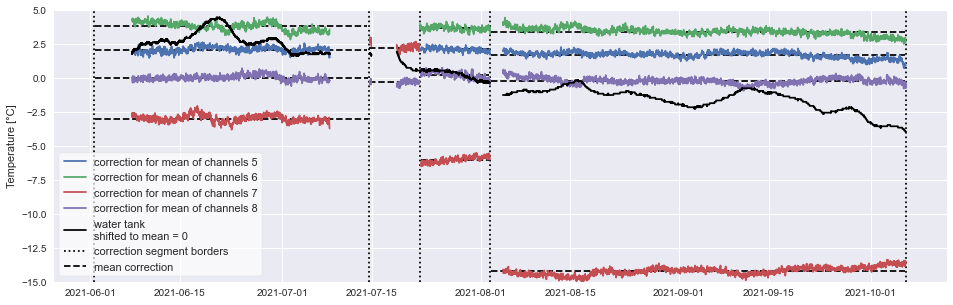

In [20]:
# Plot correction segments and values
plot_segments_mean_correction(calibration_segments_mean_correction,dates,calibration_segments_mean_correction_dates,watertank_diff_log_data_all,
                                df_Tlogger,watertank_len,ymax=5, ymin=-15)
plt.show()

# Manually correct EGRT segment channel 8, sould fit better to other data

# Correct data with const shift for each segment
Advantage: no datagaps (only the ones I want to have at segment borders)
at the moment the shift is determined with the data of the watertank correction for each sgement.

But especially for the older data of chan 1 - 4 I want to determine it from the raw data. This should be also usefull for the EGRT segment due to the large data gaps.

In [21]:
data_all_processed_constshifted = const_shift_data(["5","6","7","8"],calibration_segments, 
                                                   calibration_segments_mean_correction,data_all_processed_withoutTlogger,round_x=2)

my_Warning = check_processed_data(channels=["5","6","7","8"], data_all_processed = data_all_processed_constshifted, 
                                  gap_begin=1928+1, gap_end=2404+1)

Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


In [22]:
# Used later in plot
resampled_data={}
sample_hours=1 #need to play around with it until all chanells have same index length after resample
for chan in ["5","6","7","8"]:
    # skip first row so all dataframes start at 14:xx:xx --> resampled to same dates
    #skip last so all end at same hour; NEEDS TO BE ADAPTED WITH NEW DATA
    data_with_nan = add_nan_val_in_datagaps(data_all_processed_constshifted[chan][1:-1], minutes_gap=35)
    resampled_data[chan]=data_with_nan.resample(f"{sample_hours}H").ffill()

resampled_data["5"] = resampled_data["5"].iloc[1:]

print("Index Length:")
for chan in ["5","6","7","8"]:
    print(f"{chan}: {len(resampled_data[chan].index)}")
    print(f"first date: {resampled_data[chan].index[0]}; last date: first date: {resampled_data[chan].index[-1]}")
    
# original data
#print("Index Length:")
#for chan in ["5","6","7","8"]:
#    print(f"{chan}: {len(data_all_processed_constshifted[chan].index)}")
#    print(f"first date: {data_all_processed_constshifted[chan].index[1]};
#          last date: first date: {data_all_processed_constshifted[chan].index[-1]}")

# shorten columns so all dataframes have equal column names
for chan in ["7","8"]:
    col = resampled_data[chan].columns[1:1702]
    resampled_data[chan] = resampled_data[chan][col]

333 dates with nan have been added
333 dates with nan have been added
7 dates with nan have been added
7 dates with nan have been added
Index Length:
5: 3740
first date: 2021-06-01 14:00:00; last date: first date: 2021-11-04 09:00:00
6: 3740
first date: 2021-06-01 14:00:00; last date: first date: 2021-11-04 09:00:00
7: 3740
first date: 2021-06-01 14:00:00; last date: first date: 2021-11-04 09:00:00
8: 3740
first date: 2021-06-01 14:00:00; last date: first date: 2021-11-04 09:00:00


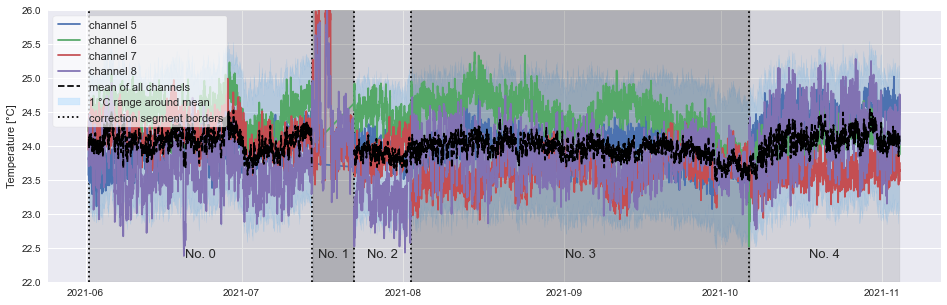

In [23]:
cable_length=800 # change me; watertank_len=[25,1689,1723,3389]
ymin=22; ymax=26

#Plot
fig,axs=plt.subplots(1,1,figsize=(16,5))
for chan in ["5","6","7","8"]:
    #axs.plot(data_all_processed_shifted[chan][800], label=f"variable shift, channel {chan},")#, color="blue")
    axs.plot(data_all_processed_constshifted[chan][cable_length],label=f"channel {chan}")#, color="green")

# mean off all channels
summe=0
# to avoid datagaps when a nan occurs; I think I need calculate this date wise.
for chan in ["5","6","7","8"]:
    summe += resampled_data[chan][cable_length]
mean=summe/4 #nan values should cause nan in mean too
axs.plot(mean,label=f"mean of all channels",color="black", linestyle="--")
axs.fill_between(mean.index,mean.values-1, mean.values+1,
                 #facecolor="blue", # The fill color
                 color='#7fc7ff',       # The outline color
                 alpha=0.3, label = "1 °C range around mean")          # Transparency of the fill

# Assecoirs
axs.vlines(dates,ymin,ymax,colors="black",linestyle=":", label="correction segment borders")    

axs.set_ylim(ymin,ymax)
axs.legend()
axs.set_ylabel("Temperature [°C]")
#axs.set_xlabel("Date")
color_cable_pos_calb_seg(calibration_segments[0],0.1, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 0", label=True)
color_cable_pos_calb_seg(calibration_segments[1],0.25, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 1", label=True)
color_cable_pos_calb_seg(calibration_segments[2],0.1, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 2", label=True)
color_cable_pos_calb_seg(calibration_segments[3],0.25, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 3", label=True)
color_cable_pos_calb_seg(calibration_segments[4],0.1, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 4", label=True)
legend = axs.legend(fontsize=11, title_fontsize=12,frameon=True,loc="upper left")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7) #not supported with eps

if masterthesis_save:
    # Save additional information so I can read them in my tex file
    save_values_in_file(3,"cable_length_plot_final_data_ch58_one_length",cable_length,r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\values_for_read_in_tex.txt")
    
    plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\final_data_ch58_one_length.pdf", format="pdf",bbox_inches="tight")
    plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\final_data_ch58_one_length.png", format="png",bbox_inches="tight",dpi=300)
plt.show()

5
333 dates with nan have been added

6
333 dates with nan have been added

7
7 dates with nan have been added

8
7 dates with nan have been added

Number of dates in Channel 5: 1248
Number of dates in Channel 6: 1248
Number of dates in Channel 7: 1248
Number of dates in Channel 8: 1248


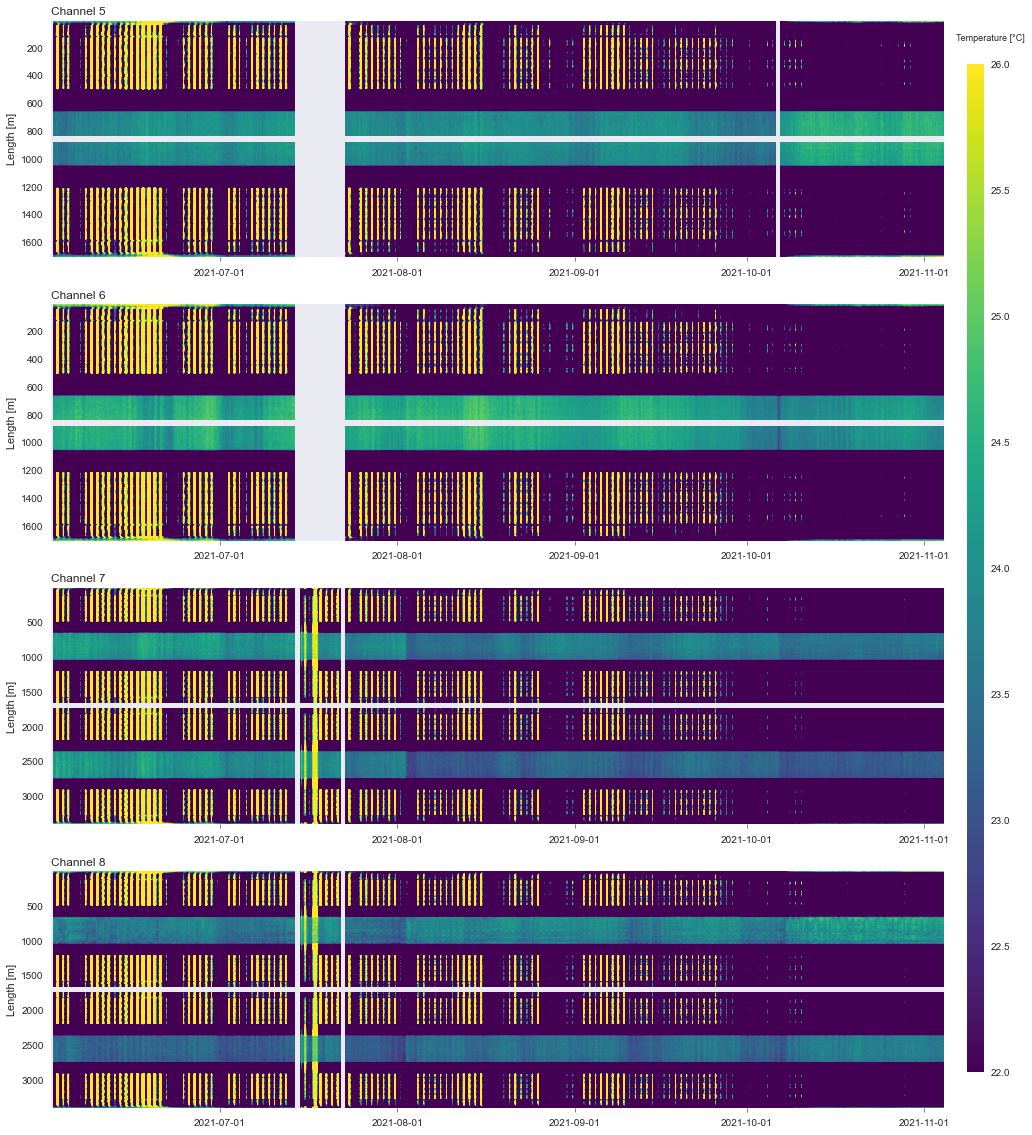

In [24]:
# Plot Carpet processed constshifted
if show_large_plot:     
    carpet_plot_with_gaps(data_all_processed_constshifted,["5","6","7","8"],title_prefix="",sample_hours=3,
                         vmin=22,vmax=26)
    plt.show()

In [25]:
# # Compare plot
# # über große Zeiten ändert sich die Temperatur relativ stark
# # Im Schacht aber eher nicht
# # man muss drauf achten, dass beide Seiten gleich viel Tag und Nacht haben und gleiches Wetter
# x=42 # how many dates to use for mean; one channel makes about 42 measurements in 24 hours
# segment_border=1929 #1929, position of segment border; change it to a non-segment border for comparisson to that this method is not good
# mean = data_all["7"].iloc[segment_border-x:segment_border].mean(axis=0) - data_all["7"].iloc[segment_border:segment_border+x].mean(axis=0)
# plt.plot(mean)
# plt.show()
# # Sehr interressant könnte ich Norbert zeigen

## Aveargae Channels from constshift data

In [26]:
# Create mean of channels
if calc_shiftfirst:
    mean_constshift = {}
    # Vorsicht hier anders rum als in averagefirst!!!
    mean_constshift["5and6"] = avearge_two_channels(data_all_processed_constshifted["5"], data_all_processed_constshifted["6"])
    mean_constshift["7and8"] = avearge_two_channels(data_all_processed_constshifted["7"], data_all_processed_constshifted["8"])

    mean_constshift["7and8"] = round(mean_constshift["7and8"],1)
    mean_constshift["5and6"] = round(mean_constshift["5and6"],1)

In [27]:
# Save const shift
if data_save:
    write_pickle(path_DTS_processed + "\import_data_scripts\data_ch5-8_processed_constshifted",data_all_processed_constshifted)
    if calc_shiftfirst:
        write_pickle(path_DTS_processed + "\import_data_scriptsl\mean_ch5-8_constshift",mean_constshift)

# Averagefirst and constshift after that

In [28]:
chan_mean_avearagefirst_not_shifted_withoutTlogger={}
data_dic=data_all_processed_withoutTlogger

# chan_mean_avearagefirst_not_shifted_withoutTlogger["5and6"]=avearge_two_channels(data_dic["5"], data_dic["6"])
# this way round the results are more similar to 7and8
chan_mean_avearagefirst_not_shifted_withoutTlogger["5and6"]=avearge_two_channels(data_dic["6"],data_dic["5"])
# is solexperts comparison better if I flip 78? --> No! it is worse
chan_mean_avearagefirst_not_shifted_withoutTlogger["7and8"]=avearge_two_channels(data_dic["7"], data_dic["8"])
# chan_mean_avearagefirst_not_shifted_withoutTlogger["7and8"]=avearge_two_channels(data_dic["8"], data_dic["7"])

chan_mean_avearagefirst_not_shifted_Tlogger = cut_dataframe_to_range_tlogger(
                                                channels=["5and6","7and8"],data = chan_mean_avearagefirst_not_shifted_withoutTlogger,do_check=True, 
                                                watertank_T_range_min = watertank_T_range_min, watertank_T_range_max = watertank_T_range_max)

data_all_processed_shifted_averagefirst, watertank_diff_log_data_all_averagefirst = watertank_shift(
                                                    chan_mean_avearagefirst_not_shifted_Tlogger, df_Tlogger, watertank_len=watertank_len,
                                                    watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max, 
                                                    channels=["5and6","7and8"],time_diff_warning=5)

calibration_segments_mean_correction_averagefirst, dates_segments_averagefirst = calc_mean_for_each_segment(["5and6","7and8"], calibration_segments, 
                                                                                    watertank_diff_log_data_all_averagefirst, watertank_len)
#RuntimeWarning: Mean of empty slice is useless here: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice

# Compare both constshift Ansätze wie im analyse Skript
calibration_segments_mean_correction_averagefirst


Channel: 5and6; Number of dates: 5076
first (oldes) date: 2021-06-07 11:58:21
last (newest) date: 2021-10-06 10:32:51

Channel: 7and8; Number of dates: 5552
first (oldes) date: 2021-06-07 12:06:22
last (newest) date: 2021-10-06 10:40:51
Warning2 from temp_watertank_func: timediff larger than 5 minutes: -1 days +23:45:41 at requested date of: 2021-06-07 11:58:21
Warning2 from temp_watertank_func: timediff larger than 5 minutes: -1 days +23:53:42 at requested date of: 2021-06-07 12:06:22


c:\Users\Mathis\ownCloud\DTS Data\Scripts\my_func_mvw\functions_dts_processing.py:246: RuntimeWarning: Mean of empty slice
  segment_mean = np.nanmean(data[date_iloc_start+5:date_iloc_end-5])


{'5and6': [2.8727745664739883,
  nan,
  2.8078020833333337,
  2.442677053824363,
  nan],
 '7and8': [-1.6913872832369943,
  0.6849111111111115,
  -3.2647089397089393,
  -7.637599150141642,
  nan]}

In [29]:
# Manual correction
# Segment No. 1 (EGRT) Segment, results show a difference to surrounfing segments
manual_correction_seg_no1=True #True False
if manual_correction_seg_no1:
    calibration_segments_mean_correction_averagefirst["7and8"][1]+=0.4

################################## The following needs to be adapted with new TLogger data###############################
# for last segemnt at the moment no tlogger data
# first value copied from segemtn before
calibration_segments_mean_correction_averagefirst["5and6"][4]=2.40310552407932+0.7
calibration_segments_mean_correction_averagefirst["7and8"][4]=-7.644109419263456
#####################################################################################################################

calibration_segments_mean_correction_averagefirst

{'5and6': [2.8727745664739883,
  nan,
  2.8078020833333337,
  2.442677053824363,
  3.1031055240793197],
 '7and8': [-1.6913872832369943,
  1.0849111111111114,
  -3.2647089397089393,
  -7.637599150141642,
  -7.644109419263456]}

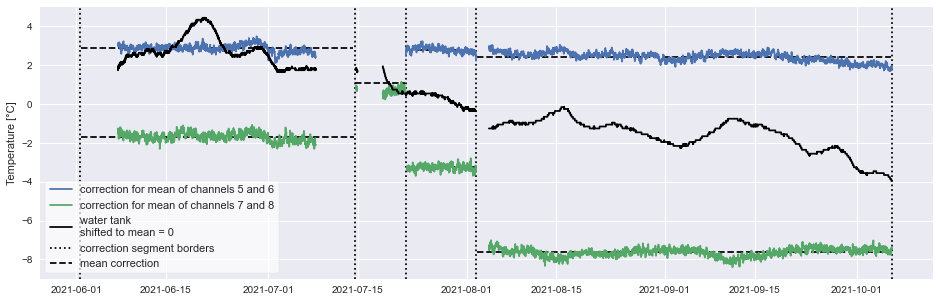

In [30]:
# Plot Correction values for averaged channels
plot_segments_mean_correction(calibration_segments_mean_correction_averagefirst,dates,dates_segments_averagefirst,
                                watertank_diff_log_data_all_averagefirst,df_Tlogger,watertank_len,ymax=5, ymin=-9)

if plot_save:
    plt.savefig(r"pictures\analyse_watertank_correction_58.png")
    if masterthesis_save:
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap3\analyse_watertank_correction_ch58.pdf", format="pdf",bbox_inches="tight")
        plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap3\analyse_watertank_correction_ch58.png", format="png",bbox_inches="tight",dpi=300)

plt.show()

In [31]:
# Apply the shifting
data_all_processed_constshifted_averagefirst = const_shift_data(["5and6","7and8"],calibration_segments, 
                                                    calibration_segments_mean_correction_averagefirst, chan_mean_avearagefirst_not_shifted_withoutTlogger,round_x=4)

# Additional corrections
only done for constshifted data

7and8 average, m: -5.7725664465690214e-05; b: 20.200401630841004; r2: 0.0006075686889223109
7and8 water average, m: -4.0360420660420566e-05; b: 24.026884145142105; r2: 0.36288274103130636
5and6 average, m: -7.597564110844249e-05; b: 19.95226639382797; r2: 0.00021564720710520735


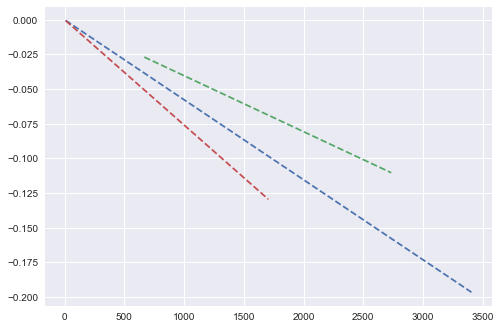

In [32]:
# find linear trend

window_size=30
border1=1 #number of length to skip at beginning
border2=1 #number of length to skip at end
mb={} # dict to save linear fits

# different masks to only select specific cable lengths; for 7and8 the positions which are in the shaft water
me=data_all_processed_constshifted_averagefirst["7and8"].mean(axis=0)
first_water_mask=np.logical_and(np.where(me.index > 665,True,False),np.where(me.index < 1035,True,False))
second_water_mask=np.logical_and(np.where(me.index > 2365,True,False),np.where(me.index < 2735,True,False))
both_water_mask=np.logical_or(first_water_mask,second_water_mask)

def find_linear_trend(data,mb=mb,channel="7and8", window_size=window_size):
    """fit a linear trend to data, returns slope (m) and y-intercept (b) in mb variable"""
    data=data.rolling(window_size,min_periods=3, center = True).mean()
    x=data.index
    y=data.values
    #Linear fit
    mb[channel],cov = np.polyfit(x, y, 1,cov=True)
    predict=np.poly1d(mb[channel])
    r2=r2_score(y, predict(x))
    # Plot
    plt.plot(x,x*mb[channel][0]+0,linestyle="--", label=f"linear fit of average {channel}")
    #Print
    mb_print=mb[channel]
    print(f"{channel} average, m: {mb_print[0]}; b: {mb_print[1]}; r2: {r2}")

    return mb

# # 7and8 
data=data_all_processed_constshifted_averagefirst["7and8"].mean(axis=0)[border1:-border2]
mb = find_linear_trend(data,mb=mb,channel="7and8")

# # 7and8 Only shaft water
data=data_all_processed_constshifted_averagefirst["7and8"].mean(axis=0)[both_water_mask]
mb = find_linear_trend(data,mb=mb,channel="7and8 water")

# # 5and6
data=data_all_processed_constshifted_averagefirst["5and6"].mean(axis=0)[border1:-border2]
mb = find_linear_trend(data,mb=mb,channel="5and6")

plt.show()
linear_trend_correction={}
linear_trend_correction["5and6"]=-1*mb["5and6"][0]
linear_trend_correction["7and8"]=-1*mb["7and8 water"][0] # mroe stable results than complete data

In [33]:
# correct linear trend
data_all_processed_constshifted_averagefirst_additionalcorr=correct_lienar_trend(data_all_processed_constshifted_averagefirst,linear_trend_correction)

del data_all_processed_constshifted_averagefirst #to make sure it is not used in one of the later cells

In [34]:
if data_save: 
    write_pickle(path_DTS_processed + "\import_data_scripts\mean_ch5-8_constshift_averagefirst", data_all_processed_constshifted_averagefirst_additionalcorr)

5and6
333 dates with nan have been added

7and8
7 dates with nan have been added

Number of dates in Channel 5and6: 1248
Number of dates in Channel 7and8: 1248


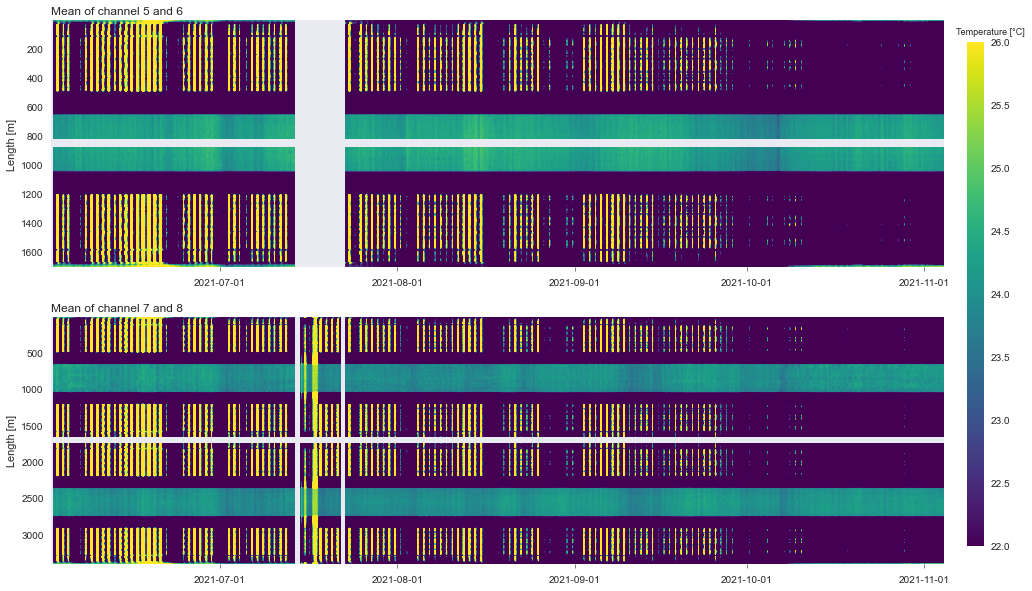

In [35]:
# Plot Carpet final processed data
if show_large_plot:     
    carpet_plot_with_gaps(data_all_processed_constshifted_averagefirst_additionalcorr,["5and6","7and8"],title_prefix="Mean of ",sample_hours=3,
                         vmin=22,vmax=26)
    if plot_save:
        plt.savefig(r"pictures\final_data_ch58_carpet.png")
        if masterthesis_save:
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix\final_data_ch58_carpet.pdf", format="pdf",bbox_inches="tight")
            plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\appendix_raster\final_data_ch58_carpet.png", format="png",bbox_inches="tight",dpi=300)
    plt.show()

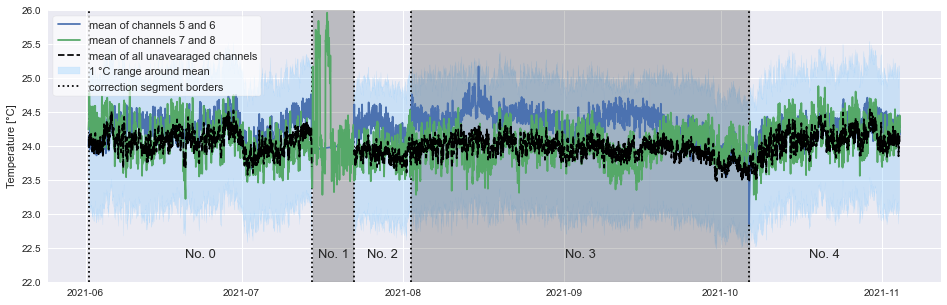

Cable length: 800 m


In [36]:
# compare avearged values to unavearaged ones - plot
cable_length=800 #watertank_len=[25,1689,1723,3389]
data=data_all_processed_constshifted_averagefirst_additionalcorr
ymin=22; ymax=26

fig,axs=plt.subplots(1,1,figsize=(16,5))
# averaged values
axs.plot(data["5and6"][cable_length].index,data["5and6"][cable_length].values,label="mean of channels 5 and 6")
axs.plot(data["7and8"][cable_length].index,data["7and8"][cable_length].values,label="mean of channels 7 and 8")

# mean off all channels - not aveargaed
summe=0
for chan in ["5","6","7","8"]:
    summe += resampled_data[chan][cable_length]
mean=summe/4 #nan values should cause nan in mean too
axs.plot(mean,label=f"mean of all unavearaged channels",color="black", linestyle="--")
axs.fill_between(mean.index,mean.values-1, mean.values+1,
                 #facecolor="blue", # The fill color
                 color='#7fc7ff',       # The outline color
                 alpha=0.3, label = "1 °C range around mean")

# Assecoirs
axs.vlines(dates,ymin,ymax,colors="black",linestyle=":", label="correction segment borders")    

axs.set_ylim(ymin,ymax)
axs.legend()
axs.set_ylabel("Temperature [°C]")
color_cable_pos_calb_seg(calibration_segments[0],0.0, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 0", label=True)
color_cable_pos_calb_seg(calibration_segments[1],0.2, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 1", label=True)
color_cable_pos_calb_seg(calibration_segments[2],0.0, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 2", label=True)
color_cable_pos_calb_seg(calibration_segments[3],0.2, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 3", label=True)
color_cable_pos_calb_seg(calibration_segments[4],0.0, ymax=ymax, ymin=ymin,axs=axs,label_name="No. 4", label=True)
legend = axs.legend(fontsize=11, title_fontsize=12,frameon=True,loc="upper left")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7)

if masterthesis_save:
    plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs\chap4\final_data_avearage_ch58_one_length.pdf", format="pdf",bbox_inches="tight")
    plt.savefig(r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\figs_raster\chap4\final_data_avearage_ch58_one_length.png", format="png",bbox_inches="tight",dpi=300)
    # Save additional information so I can read them in my tex file
    save_values_in_file(4,"cable_length_plot_final_data_avearage_ch58_one_length",cable_length,r"C:\Users\Mathis\Desktop\Masterthesis\Masterthesis_tex\values_for_read_in_tex.txt")
plt.show()
print(f"Cable length: {cable_length} m")

In [37]:
calibration_segments

[[Timestamp('2021-06-01 13:26:07'), Timestamp('2021-07-14 12:58:00')],
 [Timestamp('2021-07-14 12:58:00'), Timestamp('2021-07-22 11:50:00')],
 [Timestamp('2021-07-22 11:50:00'), Timestamp('2021-08-02 11:08:00')],
 [Timestamp('2021-08-02 11:08:00'), Timestamp('2021-10-06 11:01:47')],
 [Timestamp('2021-10-06 11:01:47'), Timestamp('2021-11-04 10:09:18')]]

In [38]:
# Investigate Segment border values

# col=data_all_processed_constshifted_averagefirst_additionalcorr["7and8"].columns[750:800] #shaft water nehemen
# dat=data_all_processed_constshifted_averagefirst_additionalcorr["7and8"][col].iloc[1927:2410]#.mean(axis=1)

# border No 1 to No 2
# data_all_processed_constshifted_averagefirst_additionalcorr["7and8"][col].iloc[2395:2415]

# border No 0 to No 1
# data_all_processed_constshifted_averagefirst_additionalcorr["7and8"][col].iloc[1920:1935]

## Extract Shaft
Only mean of channels 7 and 8 is saved. Because channels 5 and 6 have much more noise around the bend point


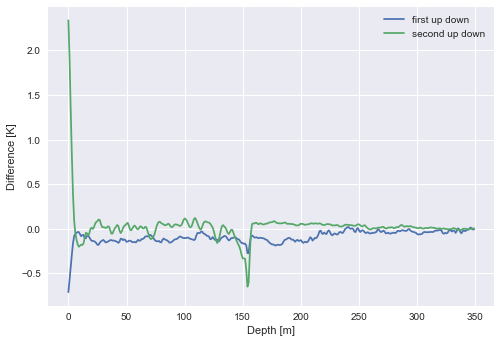

In [39]:
data_to_extract_from=data_all_processed_constshifted_averagefirst_additionalcorr

# these are the values in meter, also used in other plots for coloring
begin_borehole_0 = 506 #begin first round in shaft
end_borehole_0   = 1205

begin_borehole_1 = 2209 #begin second round in shaft
end_borehole_1   = 2908

new_column_names=np.arange(0, end_borehole_0 - begin_borehole_0 + 1, 1)
def extract_shaft(df_input, new_column_names=new_column_names):
    """"""
    df=deepcopy(df_input)
    df.columns=new_column_names
    # the names "down" and "up" are not really correct because its the avearaged data
    Schacht_7and8_down_columns = df.columns[0:int(len(df.columns)/2)]
    Schacht_7and8_down = df[Schacht_7and8_down_columns]
    Schacht_7and8_down.columns.names = ["Depth [m]"]

    Schacht_7and8_up_columns = df.columns[int(len(df.columns)/2):]
    Schacht_7and8_up = df[Schacht_7and8_up_columns]
    Schacht_7and8_up.columns = Schacht_7and8_down.columns[::-1] # rename the columns so they fit to borehole depth
    Schacht_7and8_up = Schacht_7and8_up[Schacht_7and8_up.columns[::-1]]

    # remove unecessary digits
    Schacht_7and8_up = round(Schacht_7and8_up, 1)
    Schacht_7and8_down = round(Schacht_7and8_down, 1)

    return Schacht_7and8_down, Schacht_7and8_up

# extract both borehole positions
borehole_0_columnnames=data_to_extract_from["7and8"].columns[begin_borehole_0-6:end_borehole_0-5] # due to deleting some columns during processing
Schacht_7and8_0 = data_to_extract_from["7and8"][borehole_0_columnnames]
borehole_1_columnnames=data_to_extract_from["7and8"].columns[begin_borehole_1-9:end_borehole_1-8]
Schacht_7and8_1 = data_to_extract_from["7and8"][borehole_1_columnnames]

Schacht_7and8_0_down, Schacht_7and8_0_up = extract_shaft(Schacht_7and8_0)
Schacht_7and8_1_down, Schacht_7and8_1_up = extract_shaft(Schacht_7and8_1)

# Check how equal up and down are
diff=Schacht_7and8_0_up.mean(axis=0) - Schacht_7and8_0_down.mean(axis=0)
plt.plot(diff,label="first up down")

diff=Schacht_7and8_1_up.mean(axis=0) - Schacht_7and8_1_down.mean(axis=0)
plt.plot(diff,label="second up down")
plt.xlabel("Depth [m]")
plt.ylabel("Difference [K]")
plt.legend()
plt.show()

# vielleicht ist tiefe Temperatur am Anfang vom Schacht auch durch umknicken vom Kabel? Oder es berührt Metallstreben?
# ist jetzt in diesem Plot nicht dargestellt

In [40]:
# Save final Temperature Shaft
if data_save:
    # Pickle
    save_to=r"..\Alsdorf\Daten\DTS_processed\shaft_temperatures\egrt_cable\pickle"
    filename=f"\\Schacht_7and8_down"
    write_pickle(save_to+filename,Schacht_7and8_0_down)
    filename=f"\\Schacht_7and8_up"
    write_pickle(save_to+filename,Schacht_7and8_0_up)
    # csv
    save_to=r"..\Alsdorf\Daten\DTS_processed\shaft_temperatures\egrt_cable\csv"
    filename=f"\\Schacht_7and8_down"
    Schacht_7and8_0_down.to_csv(save_to+filename+".csv")
    filename=f"\\Schacht_7and8_up"
    Schacht_7and8_0_up.to_csv(save_to+filename+".csv")

In [41]:
# Plot water tank temp and corrected DTS temp in water tank
plot_find_watertankPosition=False
watertank_EGRT = watertank_len
#Caution!! bei processing lösche ich einige Werte, sodass index sich ändert!!!
# --> data_all sollte nicht verwendet werden zu bestimmung der Wassertank position
if plot_find_watertankPosition:
    data=data_all_processed_constshifted #data_all_processed

    fig, axs = plt.subplots(figsize=(18,5))
    axs.plot(df_Tlogger.index[:], df_Tlogger["Channel1-Watertank"][:], label="water tank")
    
    for length in [25]:#watertank_EGRT: 
        channel="7"
        inde=data[channel][str(df_Tlogger.index[:].min()) : str(df_Tlogger.index[:].max())][length].index
        val=data[channel][str(df_Tlogger.index[:].min()) : str(df_Tlogger.index[:].max())][length].values
        l=data[channel][length].name
        axs.plot(inde,val, label=f"channel {channel} constant shifted, length: {l} m")

    for length in [3389]:#watertank_EGRT: 
        channel="8"
        inde=data[channel][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][length].index
        val=data[channel][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][length].values
        l=data[channel][length].name
        plt.plot(inde,val, label=f"channel {channel} constant shifted, length: {l} m")

    for length in [3389]:#watertank_EGRT: 
        channel="7and8"
        data=data_all_processed_constshifted_averagefirst_additionalcorr #data_all_processed_constshifted_averagefirst #mean_constshift
        inde=data[channel][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][length].index
        val=data[channel][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][length].values
        l=data[channel][length].name
        plt.plot(inde,val, label=f"channel mean {channel}, length: {l} m\ncolumns are equal to chan 8")

    # Assecoirs
    font=20
    axs.set_ylabel("Temperature [°C]",fontsize=font)
    #axs.set_xlabel("Date",fontsize=16)
    axs.set_title("corrected Data Compared to Watertank",fontsize=font)
    axs.tick_params(axis='x', which='major', labelsize=font-2, labelrotation=15)
    axs.tick_params(axis='y', which='major', labelsize=font-2, labelrotation=0)
    legend = axs.legend(fontsize=font-4, frameon=True)
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor("white")
    plt.show()

In [42]:
if do_checks:
    # Test is avearaging function works as expected
    # check if the watertank positions of the two channels are avearaged
    test_data1 = deepcopy(data_all_processed_withoutTlogger["7"][::20])
    test_data2 = deepcopy(data_all_processed_withoutTlogger["8"][::20])
    test_data3 = deepcopy(data_all_processed_withoutTlogger["5"][::20])
    test_data4 = deepcopy(data_all_processed_withoutTlogger["6"][::20])

    for column in test_data1.columns:
        test_data1[column] = 10
    for column in test_data2.columns:
        test_data2[column] = 30
    for column in test_data3.columns:
        test_data3[column] = 10
    for column in test_data4.columns:
        test_data4[column] = 30

    # watertank_positions
    # Each pair here should be avearaged, the result of each pair is 2
    test_data1[watertank_len[0]] = 1
    test_data2[watertank_len[3]] = 3

    test_data1[watertank_len[1]] = -1
    test_data2[watertank_len[2]] = 5

    test_data1[watertank_len[2]] = -2
    test_data2[watertank_len[1]] = 6

    test_data1[watertank_len[3]] = -3
    test_data2[watertank_len[0]] = 7

    # Channels 5 and 6
    test_data3[watertank_len[0]] = 1
    test_data4[watertank_len[1]] = 3

    test_data3[watertank_len[1]] = -1
    test_data4[watertank_len[0]] = 5

    # expected behavior: at watertank positions the avearage should be 2, everywhere else 20
    # if a watertankposition is not avearaged with its partner the result will be different
    test_result_12 = avearge_two_channels(test_data1, test_data2)
    test_result_34 = avearge_two_channels(test_data3, test_data4)
    
    # Check Test results
    error=False
    for watank_len in watertank_len:
        if test_result_12[watank_len].mean() != 2:
            error=True
            print(f"Test failed at {watank_len}, something is wrong in avearaging the data.")
    if error ==False:
        print("test channel 7 and 8 passed")
        del test_data1
        del test_data2
        del test_result_12
    else:
        print("test channel 7 and 8 failed")
    print()
    
    # channels 5 and 6
    error=False
    for watank_len in watertank_len[:2]:
        if test_result_34[watank_len].mean() != 2:
            error=True
            print(f"Test failed at {watank_len}, something is wrong in avearaging the data.")
    if error ==False:
        print("test channel 5 and 6 passed")
        del test_data3
        del test_data4
        del test_result_34
    else:
        print("test channel 5 and 6 failed")

test channel 7 and 8 passed

test channel 5 and 6 passed
